In [49]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os.path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow import keras




In [ ]:
train_dir=Path('dataset/train')
train_filepaths=list(train_dir.glob(r'**/*.jpg'))


dataset\train
[WindowsPath('dataset/train/apple/Image_1.jpg'), WindowsPath('dataset/train/apple/Image_10.jpg'), WindowsPath('dataset/train/apple/Image_16.jpg'), WindowsPath('dataset/train/apple/Image_17.jpg'), WindowsPath('dataset/train/apple/Image_18.jpg'), WindowsPath('dataset/train/apple/Image_19.jpg'), WindowsPath('dataset/train/apple/Image_2.jpg'), WindowsPath('dataset/train/apple/Image_20.jpg'), WindowsPath('dataset/train/apple/Image_21.jpg'), WindowsPath('dataset/train/apple/Image_23.jpg'), WindowsPath('dataset/train/apple/Image_24.jpg'), WindowsPath('dataset/train/apple/Image_25.jpg'), WindowsPath('dataset/train/apple/Image_26.jpg'), WindowsPath('dataset/train/apple/Image_27.jpg'), WindowsPath('dataset/train/apple/Image_28.jpg'), WindowsPath('dataset/train/apple/Image_3.jpg'), WindowsPath('dataset/train/apple/Image_31.jpg'), WindowsPath('dataset/train/apple/Image_32.jpg'), WindowsPath('dataset/train/apple/Image_33.jpg'), WindowsPath('dataset/train/apple/Image_34.jpg'), WindowsP

In [17]:
test_dir=Path('dataset/test')
test_filepaths=list(test_dir.glob(r'**/*.jpg'))


In [18]:
val_dir=Path('dataset/validation')
val_filepaths=list(val_dir.glob(r'**/*.jpg'))


In [19]:


def image_processing(filepath):
   labels = [os.path.basename(os.path.dirname(str(path))) for path in filepath]
#    print(labels)
   filepath=pd.Series(filepath,name="Filepath").astype(str)
   labels=pd.Series(labels,name='Label')

   df=pd.concat([filepath,labels],axis=1)
   # print(df)
   df=df.sample(frac=1).reset_index(drop=True)
   
   return df

      

In [20]:
train_df=image_processing(train_filepaths)
test_df=image_processing(test_filepaths)
val_df=image_processing(val_filepaths)

In [21]:
train_df.head(5)

,Filepath,Label
0,dataset\train\corn\Image_10.jpg,corn
1,dataset\train\mango\Image_53.jpg,mango
2,dataset\train\kiwi\Image_18.jpg,kiwi
3,dataset\train\soy beans\Image_79.jpg,soy beans
4,dataset\train\cucumber\Image_79.jpg,cucumber


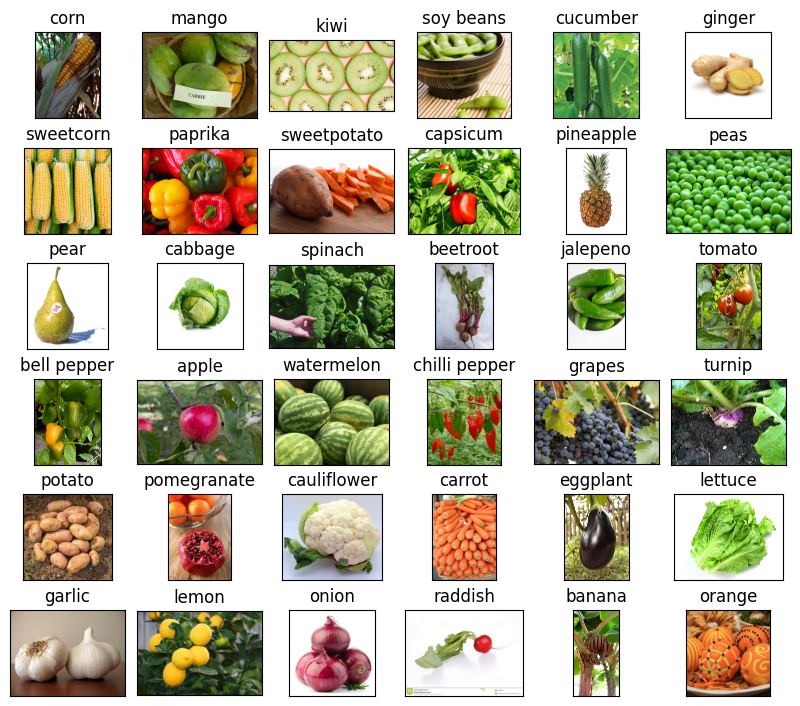

In [23]:
df_unique=train_df.copy().drop_duplicates(subset=['Label']).reset_index()

fig, axes=plt.subplots(nrows=6,ncols=6,figsize=(8,7),subplot_kw={'xticks':[],'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i],fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()    

In [26]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [29]:
train_images=train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(224, 224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=0,
rotation_range=30,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [41]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [38]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [31]:
pretrained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable=False

In [39]:
inputs=pretrained_model.input
x=tf.keras.layers.Dense(128,activation='relu')(pretrained_model.output)
x=tf.keras.layers.Dense(128,activation='relu')(x)

outputs=tf.keras.layers.Dense(36,activation='softmax')(x)

model=tf.keras.Model(inputs=inputs,outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
 
history=model.fit(
    train_images,
    validation_data=val_images,
    batch_size=32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
    
)

f:\My projects\FruitAi\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.3472 - loss: 2.4896 - val_accuracy: 0.8706 - val_loss: 0.4890
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.8146 - loss: 0.6142 - val_accuracy: 0.9382 - val_loss: 0.2593
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.8932 - loss: 0.3464 - val_accuracy: 0.9324 - val_loss: 0.2325
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9363 - loss: 0.2053 - val_accuracy: 0.9471 - val_loss: 0.2340
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9655 - loss: 0.1378 - val_accuracy: 0.9618 - val_loss: 0.1821


In [43]:
pred=model.predict(test_images)
pred=np.argmax(pred,axis=1)

labels=(train_images.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred1=[labels[k] for k in pred]
pred1


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


['sweetpotato',
 'garlic',
 'banana',
 'sweetcorn',
 'apple',
 'pineapple',
 'lettuce',
 'capsicum',
 'turnip',
 'jalepeno',
 'pineapple',
 'corn',
 'kiwi',
 'corn',
 'spinach',
 'garlic',
 'raddish',
 'grapes',
 'corn',
 'grapes',
 'kiwi',
 'peas',
 'mango',
 'grapes',
 'pineapple',
 'bell pepper',
 'spinach',
 'pineapple',
 'pear',
 'beetroot',
 'sweetcorn',
 'raddish',
 'garlic',
 'carrot',
 'beetroot',
 'pomegranate',
 'pomegranate',
 'cabbage',
 'onion',
 'cauliflower',
 'jalepeno',
 'orange',
 'soy beans',
 'capsicum',
 'sweetpotato',
 'lemon',
 'grapes',
 'peas',
 'paprika',
 'grapes',
 'sweetcorn',
 'capsicum',
 'capsicum',
 'peas',
 'cabbage',
 'onion',
 'cauliflower',
 'pomegranate',
 'soy beans',
 'sweetpotato',
 'paprika',
 'cauliflower',
 'garlic',
 'potato',
 'jalepeno',
 'chilli pepper',
 'corn',
 'eggplant',
 'pineapple',
 'orange',
 'pear',
 'ginger',
 'pear',
 'turnip',
 'mango',
 'kiwi',
 'banana',
 'spinach',
 'watermelon',
 'ginger',
 'pomegranate',
 'cucumber',
 '

In [44]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [51]:
model.save('FV.h5')